# Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import time
from pprint import pprint
import dill as pickle
from sklearn.utils.fixes import loguniform

# Model selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Model optimization
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

from sklearn.utils import class_weight

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import SVC

# performance metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

In [ ]:
df = pd.read_csv('../data/interim/covid_articles_tfidf.csv')
df.head()

In [3]:
df.topic_area.value_counts()

business        244422
general          84921
finance          22386
tech              8676
science           3478
consumer          1451
healthcare        1340
automotive         925
environment        777
construction       305
ai                 239
Name: topic_area, dtype: int64

Since the number of articles per topic area are not balanced, I will filter out the tags with low frequency. Alternatively, I may merge the excluded tags with the closest tag with higher frequency.

In [4]:
min_samples = 10000

filter_topics = df['topic_area'].value_counts().to_frame()
filter_topics = filter_topics[filter_topics['topic_area']>min_samples].index
df_majority = df[df['topic_area'].isin(filter_topics)].drop(columns='title')
print(df_majority.shape)
df_majority.head()

(351729, 1001)


,topic_area,ability,able,accelerate,access,accord,accordance,account,accounting,achieve,...,worker,world,worth,would,write,year,yet,yield,york,young
0,business,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.03,0.02,0.12,0.03,0.11,0.00,0.0
1,business,0.03,0.00,0.0,0.0,0.04,0.0,0.0,0.0,0.0,...,0.06,0.00,0.0,0.02,0.03,0.17,0.00,0.12,0.00,0.0
2,business,0.00,0.02,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.11,0.02,0.05,0.08,0.00,0.00,0.0
6,business,0.00,0.03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.04,0.03,0.09,0.04,0.00,0.04,0.0
7,general,0.00,0.03,0.0,0.0,0.21,0.0,0.0,0.0,0.0,...,0.03,0.05,0.0,0.02,0.00,0.03,0.00,0.00,0.00,0.0


### Encode labels
We can use onehotencoder or label encoder to transform the labels. However, scikit learn can digest text labels and I will use text labels for now. The script below will be used if I need encoded labels in the future.

In [5]:
def label_enc(array):
    enc = LabelEncoder()
    #y = df_majority.topic_area.values
    array = enc.fit_transform(array)
    n_classes = len(enc.classes_[0])
    return array, n_classes

In [6]:
def ordinal_enc(array):
    enc = OrdinalEncoder()
    #y = df_majority.topic_area.values
    array = enc.fit_transform(array.reshape(-1,1))
    n_classes = len(enc.categories_[0])
    return array, n_classes

In [7]:
def onehot_enc(array):
    enc = OneHotEncoder()
    #y = df_majority.topic_area.values.reshape(-1,1)
    array = enc.fit_transform(array.reshape(-1,1)).toarray()
    n_classes = len(enc.categories_[0])
    #print((enc.categories_))
    return array, n_classes, enc.categories_[0]

### ROC Curve for Multiclass Classification

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

I use the following function to generate ROC curve for the exisitng multi-class problem.

In [8]:
def roc_calc(y_test, y_pred_prob):
    
    y_test_enc, n_classes, categories = onehot_enc(y_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_enc[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc, categories

In [9]:
def roc_plot(fpr, tpr, roc_auc, categories):
    lw = 2
        
    fig = plt.figure(figsize=(10,30))
    for i in range(len(categories)):
        ax = fig.add_subplot(6,2,i+1)
        ax.plot(fpr[i], tpr[i], color='r',
         lw=lw, label='ROC curve - (area = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], color='b', lw=lw, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title("Receiver operating characteristic - {}".format(categories[i]))
        ax.legend(loc="lower right")
        ax.plot()

### Precision Recall Curve

Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.

The precision_recall_curve computes a precision-recall curve from the ground truth label and a score given by the classifier by varying a decision threshold. I use the follwoing function to calculate and plot the precision and recall for the existing multi-class problem.

In [10]:
# For each class
def pre_rec_calc(y_test, y_pred_prob):
    
    y_test_enc, n_classes, _ = onehot_enc(y_test)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_enc[:, i], y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_test_enc[:, i], y_pred_prob[:, i])
    
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_test_enc.ravel(), y_pred_prob.ravel()
    )
    average_precision["micro"] = average_precision_score(y_test_enc, y_pred_prob, average="micro")
    
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot()
    _ = display.ax_.set_title("Micro-averaged over all classes")
    
    return precision, recall, average_precision

In [11]:
# setup plot details
def pre_rec_plot(precision, recall, average_precision):
    
    y_test_enc, n_classes, categories = onehot_enc(y_test)
    
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
    
    _, ax = plt.subplots(figsize=(7, 8))
    
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
        
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
        
    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {categories[i]}", color=color)
    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Extension of Precision-Recall curve to multi-class")
    
    plt.show()

### Train and Test Data

In [12]:
X = df_majority.drop(columns='topic_area')
y = df_majority.topic_area.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

## Classifiers
I will apply NaiveBayes, Logistic Regression, SGD, and SVM classifiers on the data.

### Naive Bayes

In [13]:
# Naive Bayes
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)
y_pred_prob = clf_nb.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.84      0.83      0.84     73389
     finance       0.67      0.00      0.01      6628
     general       0.61      0.78      0.68     25502

    accuracy                           0.77    105519
   macro avg       0.70      0.54      0.51    105519
weighted avg       0.77      0.77      0.75    105519



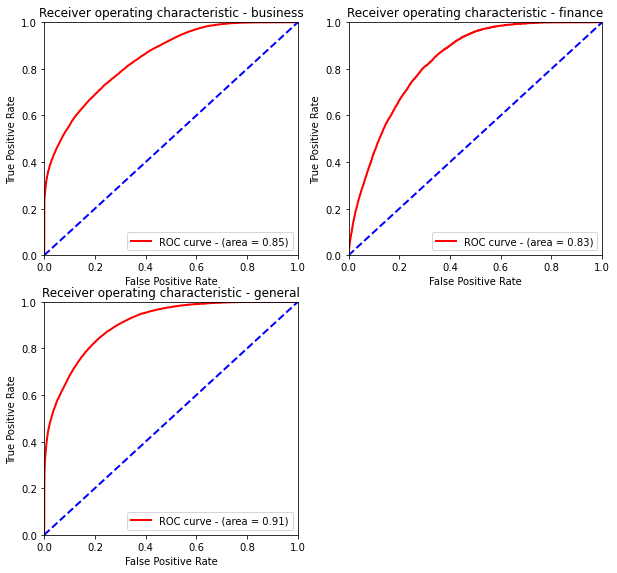

In [14]:
fpr, tpr, roc_auc, categories = roc_calc(y_test, y_pred_prob)
roc_plot(fpr, tpr, roc_auc, categories)

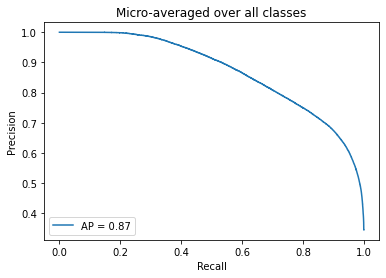

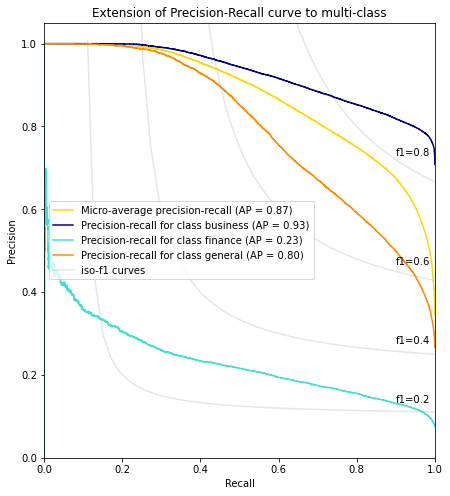

In [15]:
precision, recall, average_precision = pre_rec_calc(y_test, y_pred_prob)
pre_rec_plot(precision, recall, average_precision)

### Logistic Regression

In [16]:
clf_lr = LogisticRegression(solver='liblinear')
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)
y_pred_prob = clf_lr.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.87      0.96      0.91     73389
     finance       0.75      0.30      0.43      6628
     general       0.87      0.75      0.80     25502

    accuracy                           0.86    105519
   macro avg       0.83      0.67      0.71    105519
weighted avg       0.86      0.86      0.85    105519



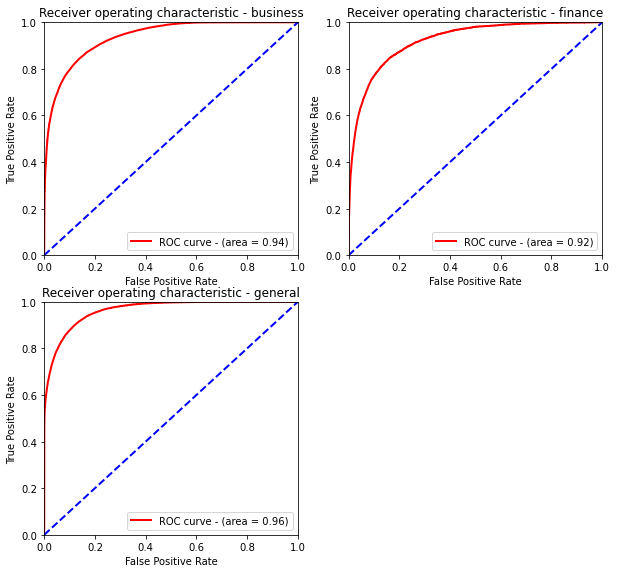

In [17]:
fpr, tpr, roc_auc, categories = roc_calc(y_test, y_pred_prob)
roc_plot(fpr, tpr, roc_auc, categories)

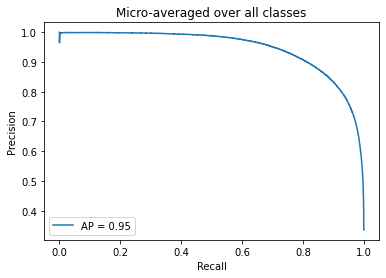

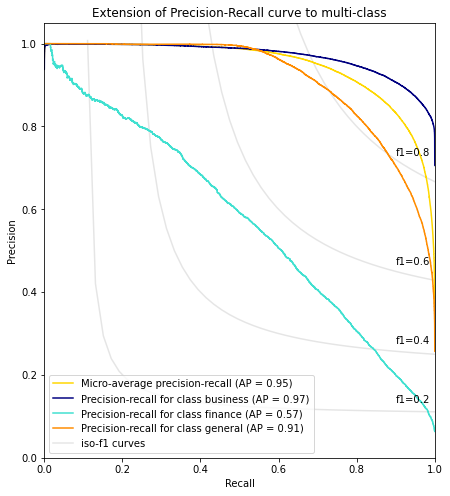

In [18]:
precision, recall, average_precision = pre_rec_calc(y_test, y_pred_prob)
pre_rec_plot(precision, recall, average_precision)

### SGD Classifier

In [19]:
clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)

print(classification_report(y_test, y_pred))

C:\Users\rasaee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    business       0.80      1.00      0.89     73389
     finance       0.00      0.00      0.00      6628
     general       1.00      0.52      0.69     25502

    accuracy                           0.82    105519
   macro avg       0.60      0.51      0.52    105519
weighted avg       0.79      0.82      0.78    105519



### SVM Classifier
SVC and NuSVC implement the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes. To provide a consistent interface with other classifiers, the decision_function_shape option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes).

In [38]:
from sklearn.svm import SVC

clf_svm = SVC(decision_function_shape='ovo')
clf_svm.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [40]:
y_pred = clf_svm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.90      0.97      0.94     73389
     finance       0.91      0.50      0.64      6628
     general       0.92      0.81      0.86     25502

    accuracy                           0.90    105519
   macro avg       0.91      0.76      0.81    105519
weighted avg       0.91      0.90      0.90    105519



In [44]:
"""
# save the model to disk
filename = '../models/svm_model.sav'
pickle.dump(clf_svm, open(filename, 'wb'))

# load the model from disk
clf_svm_loaded = pickle.load(open(filename, 'rb'))
"""

"\n# save the model to disk\nfilename = '../models/svm_model.sav'\npickle.dump(clf_svm, open(filename, 'wb'))\n\n# load the model from disk\nclf_svm_loaded = pickle.load(open(filename, 'rb'))\n"

## Hyperparameter Tuning
To study the hyperparameter space and improve model performance, I created a pipeline to put all these steps together and find an optimum hyperparamter space.

### Class Weights
Giving different weights to both the majority and minority classes is a way deal with imbalanced data. The weights will impact the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

In [20]:
def class_weight_gen(y_train):
    weights_classes = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    weight_dict = dict(zip(np.unique(y_train), weights_classes))
    weights = [weight_dict[x] for x in y_train]
    return weights

## Optimization Search
Two generic approaches to parameter search are provided in scikit-learn: for given values, GridSearchCV exhaustively considers all parameter combinations, while BaysianSearchCV can sample a given number of candidates from a parameter space with a specified distribution.

### BayesSearchCV
BayesSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

Parameters are presented as a list of skopt.space.Dimension objects.

In [21]:
def bayes_search_cv(pipeline, param_grid, fit_params=None, n_iter=50):
    
    search = BayesSearchCV(estimator=pipeline, search_spaces=param_grid,
                           fit_params=fit_params, n_iter=n_iter, n_jobs=5, verbose=1, random_state=21)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(param_grid)
    t0 = time.time()
    
    search.fit(X_train, y_train)
    #print("done in %0.3fs" % (time() - t0))
    print()
    
    print("Best score: %0.3f" % search.best_score_)
    print("Best parameters set:")
    best_parameters = search.best_estimator_.get_params()
    
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    y_pred = search.predict(X_test)
    y_pred_prob = search.predict_proba(X_test)
    
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, roc_auc, categories = roc_calc(y_test, y_pred_prob)
    roc_plot(fpr, tpr, roc_auc, categories)
    
    precision, recall, average_precision = pre_rec_calc(y_test, y_pred_prob)
    pre_rec_plot(precision, recall, average_precision)

## Reading Pre-processed Articles
The cleaned text from previous step is loaded into this notebook for the assessment of vectorization perfromance.

In [26]:
# Read the data
df_normal_text = pd.read_csv('../data/interim/covid_articles_normalized.csv')

# Minimum number of samples per class. Only classes that pass this threshold will be included in the model. 
min_samples = 10000

filter_topics = df_normal_text['topic_area'].value_counts().to_frame()
filter_topics = filter_topics[filter_topics['topic_area']>min_samples].index
df_select_topics = df_normal_text[df_normal_text['topic_area'].isin(filter_topics)].drop(columns='title')

In [27]:
# Split train and test data
X = df_select_topics.content.tolist()
y = df_select_topics.topic_area.values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=21)

## NaiveBayes

In [24]:
## Model Specifications
# Parameter grid
param_grid = {
    'clf__alpha': (1e-4, 1.0, "log-uniform"),
    #'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__max_features': [10000, 30000, None],
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__min_df': (3, 5, 10),
    'tfidf__use_idf': (True, False),
}

# Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Crossvalidations
cv = 5

# Fit parameters
fit_params = {'clf__sample_weight':[None, class_weight_gen(y_train)],}

# Number of iterations: Number of parameter settings that are sampled.
n_iter = 32


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.0001, 1.0, 'log-uniform'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': [10000, 30000, None]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished
C:\Users\rasaee\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished



Best score: 0.781
Best parameters set:
	clf__alpha: 1.0
	tfidf__use_idf: False
	vect__max_df: 1.0
	vect__max_features: None
              precision    recall  f1-score   support

    business       0.84      0.85      0.85     73327
     finance       1.00      0.00      0.00      6716
     general       0.64      0.78      0.70     25476

    accuracy                           0.78    105519
   macro avg       0.82      0.54      0.51    105519
weighted avg       0.80      0.78      0.76    105519



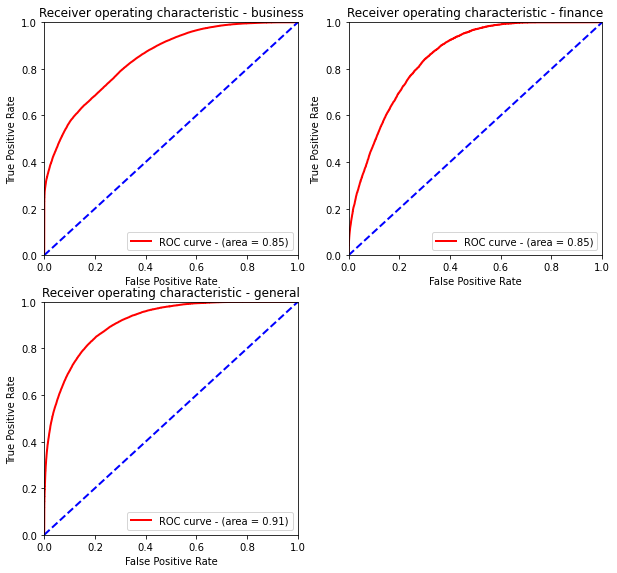

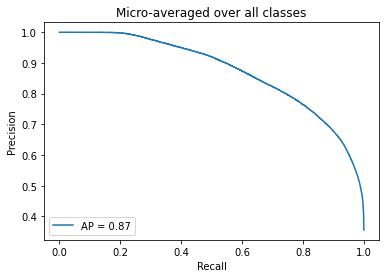

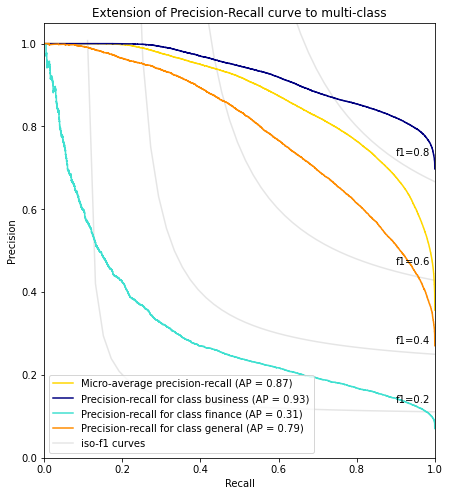

In [28]:
# Execute bayesian search
bayes_search_cv(pipeline, param_grid, fit_params=None, n_iter=n_iter)

### Logistic Regression
Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.



In [31]:
## Model Specifications
# Parameter grid
param_grid_lr = {
    #'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__max_features': [10000, 30000, None],
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__min_df': (3, 5, 10),
    'tfidf__use_idf': (True, False),
    'clf__dual': (True,False),
    'clf__max_iter': [100,110,120,130,140],
    'clf__C': (1e-5, 1e2, "log-uniform"),
}

# Pipeline
pipeline_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear', n_jobs=5))
])

# Crossvalidations
cv = 5

# Fit parameters
fit_params = {'clf__sample_weight':[None, class_weight_gen(y_train)],}

# Number of iterations: Number of parameter settings that are sampled.
n_iter = 32

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': (1e-05, 100.0, 'log-uniform'),
 'clf__dual': (True, False),
 'clf__max_iter': [100, 110, 120, 130, 140],
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': [10000, 30000, None]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 10.8min remaining: 16.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 11.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 10.4min remaining: 15.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 11.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 13.1min remaining: 19.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 14.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.9min remaining:  8.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  9.2min remaining: 13.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  9.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.6min remaining: 11.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  9.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.1min remaining:  7.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.2min remaining: 10.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  8.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.6min remaining:  5.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.3min remaining:  8.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.0min remaining:  7.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.3min remaining:  4.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 13.3min remaining: 19.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 15.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  9.9min remaining: 14.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 11.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.1min remaining:  7.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.9min remaining: 11.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  9.9min finished
C:\Users\rasaee\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn("'n_jobs' > 1 does not have any effect when"



Best score: 0.899
Best parameters set:
	clf__C: 33.63295708080422
	clf__dual: False
	clf__max_iter: 110
	tfidf__use_idf: False
	vect__max_df: 1.0
	vect__max_features: 30000
              precision    recall  f1-score   support

    business       0.91      0.95      0.93     73327
     finance       0.81      0.56      0.66      6716
     general       0.88      0.84      0.86     25476

    accuracy                           0.90    105519
   macro avg       0.87      0.78      0.82    105519
weighted avg       0.90      0.90      0.90    105519



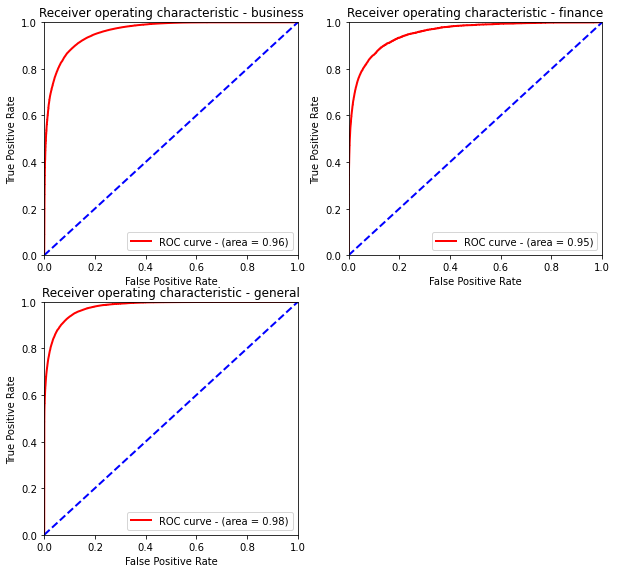

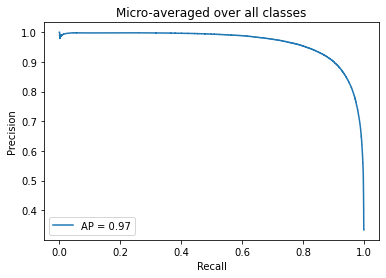

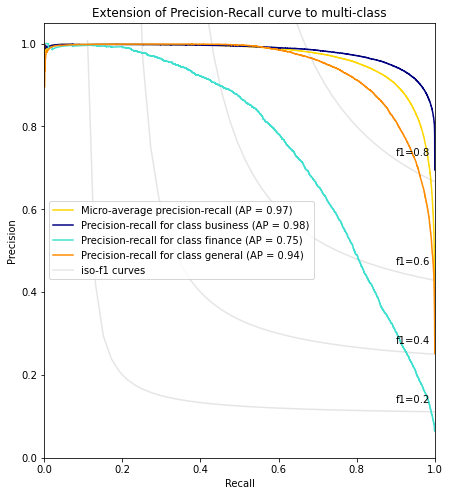

In [32]:
# Execute bayes search with logistic regression
bayes_search_cv(pipeline_lr, param_grid_lr, fit_params=None, n_iter=n_iter)